In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Cannot import mxnet.
Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [2]:
scan_parameters = {}

In [3]:
scan_parameters['stack'] = 'MD589'
scan_parameters['patch_size'] = 448
scan_parameters['patch_half_size'] = scan_parameters['patch_size']/2
scan_parameters['stride'] = 112

scan_parameters['section_limits'] = metadata_cache['section_limits'][scan_parameters['stack']]
scan_parameters['o_crop'] = True
scan_parameters['o_clear_border'] = True
scan_parameters['o_relabel'] = True
scan_parameters['oriImL1'], scan_parameters['oriImL0'] = metadata_cache['image_shape'][scan_parameters['stack']]
scan_parameters['scan_section_range'] = 1

scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','perimeter','compactness','label','major_axis_length','minor_axis_length']
scan_parameters['prop_for_comparison'] = ['area', 'eccentricity']
if 'moments_hu' in scan_parameters['prop_for_comparison']:
    scan_parameters['compare_weight'] = [1 for i in range(6 + len(scan_parameters['prop_for_comparison']))]
else:
    scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']))]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.8
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['builtInProps'] = ['centroid','orientation', 'eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','label','local_centroid','major_axis_length','solidity','minor_axis_length','perimeter','solidity']
scan_parameters['prop_to_save'] = ['coords','moments_hu','centroid','area','eccentricity','equivalent_diameter']

stack = scan_parameters['stack']

In [4]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
structure_name = '7N'
vertice_7N_dic = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()}
sectionList_7N = np.sort(vertice_7N_dic.keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


(9891, 7307, 10864, 8892)

In [97]:
bbox_7N

(9443, 6968, 11182, 8967)

In [115]:
margin = 10
bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
# bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
bbox_7N = bboxs_7N[154]
scan_parameters['crop_range_mmxx'] = bbox_7N
scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

In [116]:
# loading data
image = {}
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
# secList = range(section_begin, section_end+1)
# tempSecList = range(section_begin, section_end+1)
secList = list(sectionList_7N[0:10])
tempSecList = list(sectionList_7N[0:10])
for tempSec in tempSecList:
    try:
        image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
    except:
        sys.stderr.write('Invalid section %d...\n'%tempSec)
        secList.remove(tempSec)
        continue
#     if os.path.isfile(img_filename[tempSec]):
#         sys.stderr.write('Image file is already available. \n')
#         continue
#     else:
#         try:
#             download_from_s3(img_filename[tempSec])
#         except:
#             sys.stderr.write('Download fail. Skip this file for section %d...\n'%tempSec)
#             secList.remove(tempSec)
#             continue   
scan_parameters['secList'] = secList

In [117]:
section = 154
scan_section_range = 1
sec_load_data_list = range(section - scan_section_range, section + scan_section_range + 1)
scan_section = list(sec_load_data_list)
scan_section.remove(section)
secList = scan_parameters['secList']
stack = scan_parameters['stack']

In [118]:
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
for tempSec in sec_load_data_list:
    if tempSec in secList:
        cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
        temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                    oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
        im_label[tempSec] = temp_im_label
        im_BW[tempSec] = temp_im_label > 0
        im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
    else:
        sys.stderr.write('Warning: missing section %d'%tempSec)
        scan_section.remove(tempSec)

blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
blob_idx_selection = {tempSec : np.logical_and.reduce(np.row_stack(
    (blob_prop_dic[tempSec]['compactness']>0,
#      blob_prop_dic[tempSec]['compactness']<2.5,
     blob_prop_dic[tempSec]['area']<3000,
     blob_prop_dic[tempSec]['area']>200))) for tempSec in sec_load_data_list}

rm -rf "/shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf" && mkdir -p "/shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079"
aws s3 cp "s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf" "/shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf"


In [119]:
typical_blobs = []
matched_paris = []
scan_range = scan_parameters['scan_section_range']
scan_section = range(section - scan_range, section + scan_range + 1)
scan_section.remove(section)
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']

prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']

compare_weight = scan_parameters['compare_weight']
o_simil_threshold = scan_parameters['similarity_threshold']
n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
o_fix_scan_size = scan_parameters['o_fix_scan_size']
o_scan_size_coeff = scan_parameters['scan_size_coeff']
o_scan_size = scan_parameters['scan_size']  
secList_in_BlobPropDic = im_blob_prop.keys()

In [130]:
if set(scan_section).issubset(set(secList_in_BlobPropDic)):
    pass
else:
    print('Warrning: Scaned section(s) not included in input im_blob_prop')

for blobID in range(n_blobs[section]):
    if (blobID % 1000 == 0):
        print('Section %d Finished percentage: %f'%(section, (float(blobID)*100 / n_blobs[section]) ))
    
    temp_curr_blob_props = {}
    for tempProp in prop:
        temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][blobID]
#         if tempProp in scan_parameters['builtInProps']:
#             temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID][tempProp]
#         elif tempProp == 'compactness':
#             temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID]['perimeter']**2/(4*PI*im_blob_prop[section][blobID]['area'])
    
    if not blob_idx_selection[section][blobID]:
#         print('Blob %d eliminated'%blobID)
        continue
    
    
    
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)


    for tempSec in scan_section:
#         print('Blbo %d left. Start scanning'%blobID)
        if tempSec not in secList_in_BlobPropDic:
            continue

        # Find blobs at the nearby location in the scaned section
        # Method 1
        tempPath = matplotlib.path.Path(temp_next_sec_range)
        tempBlobInside = tempPath.contains_points(blob_prop_dic[tempSec]['centroid'])
        tempBlobInsideIndex = np.where(tempBlobInside)[0]  
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_sim = {}
            for temp_prop in prop_for_comparison:
                      temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
            temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

            #### Blob comparison ####
            temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
            temp_compare_result = temp_weighted_sim > o_simil_threshold
            if any(temp_compare_result.tolist()):
#                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                matched_paris.append([section,blobID,im_blob_prop[section][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
#             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue


Section 154 Finished percentage: 0.000000


# Visualization

In [131]:
curr_fig_blob_vis = {}
curr_fig_blob_vis[section] = image[section].copy()

matched_fig_blob_vis = {}
for tempSec in scan_section:
    matched_fig_blob_vis[tempSec] = image[tempSec].copy();
map_color = {}
for tempBlobID in set([record[1] for record in matched_paris]):
    map_color[tempBlobID] = tuple(np.random.randint(0,high=255,size=[3,])) # Color map for typical blobs in the current section

In [12]:
def fun_angle_np_to_cv2(angle):
    PI = 3.1415926
    if angle < 0:
        return -angle
    if (angle>0) and (angle < PI/2):
        return PI - angle

In [132]:
# Circle selected blobs in green and eliminated blobs in red

for tempBID in np.where(blob_idx_selection[section])[0]:
    cell_contour = skimage.measure.find_contours(im_label[section]==im_blob_prop[section][tempBID]['label'],0)[0]
    cv2.polylines(curr_fig_blob_vis[section], [cell_contour[:,::-1].astype(np.int32)], isClosed=True, color=(0,255,0),thickness=1)
for tempBID in np.where(np.logical_not(blob_idx_selection[section]))[0]:
    cell_contour = skimage.measure.find_contours(im_label[section]==im_blob_prop[section][tempBID]['label'],0)[0]
    cv2.polylines(curr_fig_blob_vis[section], [cell_contour[:,::-1].astype(np.int32)], isClosed=True, color=(255,0,0),thickness=1)

for matched_blob_id in range(len(matched_paris)):
# for matched_blob_id in [50]:
#     print(matched_blob_id)
    curr_blob_section = matched_paris[matched_blob_id][0]
    curr_blob_id = matched_paris[matched_blob_id][1]
    curr_blob_regionprops = matched_paris[matched_blob_id][2]
    scan_blobs_section = matched_paris[matched_blob_id][3]
    scan_blobs_ids = matched_paris[matched_blob_id][4]
    scan_blobs_regionprops = matched_paris[matched_blob_id][5]    
# Draw ellipses on typical blobs. Matched blob pairs are colored the same in different section
    ellipse_angle = int(fun_angle_arc_to_degree(fun_angle_np_to_cv2(blob_prop_dic[curr_blob_section]['orientation'][curr_blob_id])))
    ellipse_axes = tuple([(0.5*blob_prop_dic[curr_blob_section]['major_axis_length'][curr_blob_id]).astype(np.int),
                       (0.5*blob_prop_dic[curr_blob_section]['minor_axis_length'][curr_blob_id]).astype(np.int)])
    cell_contour = cv2.ellipse2Poly(tuple(blob_prop_dic[curr_blob_section]['centroid'][curr_blob_id][::-1].astype(np.int)),
                ellipse_axes,
               ellipse_angle,0,360,10)
    cv2.polylines(curr_fig_blob_vis[curr_blob_section], [cell_contour.astype(np.int32)], isClosed=True, color=map_color[curr_blob_id],thickness=2)

# Draw ellipses around matched blobs in scan section. 
    for scan_blob_id in scan_blobs_ids:
        ellipse_angle = int(fun_angle_arc_to_degree(fun_angle_np_to_cv2(blob_prop_dic[scan_blobs_section]['orientation'][scan_blob_id])))
        ellipse_axes = tuple([(0.5*blob_prop_dic[scan_blobs_section]['major_axis_length'][scan_blob_id]).astype(np.int),
                           (0.5*blob_prop_dic[scan_blobs_section]['minor_axis_length'][scan_blob_id]).astype(np.int)])
        cell_contour = cv2.ellipse2Poly(tuple(blob_prop_dic[scan_blobs_section]['centroid'][scan_blob_id][::-1].astype(np.int)),
                    ellipse_axes,
                   ellipse_angle,0,360,10)
        cv2.polylines(matched_fig_blob_vis[scan_blobs_section], [cell_contour.astype(np.int32)], isClosed=True, color=map_color[curr_blob_id],thickness=2)

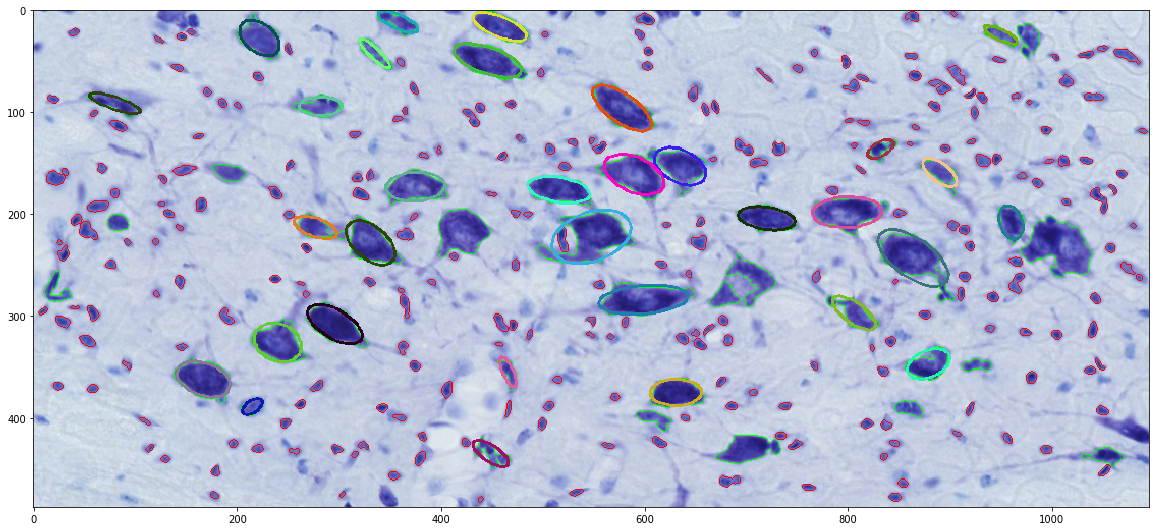

In [135]:
plt.figure(figsize=(20,20))
plt.imshow(curr_fig_blob_vis[section])

Preprocessing: we select blobs with size between 200 and 3000 pixels for typical blob matching. Eliminated blobs are labeled with red thin contours while selected blobs are labeled with green thin contours. For typical blob matching, the features we used are the area and eccentricity of the blob, which are evenly weighted to get the final similarity. 

This image shows the typical blobs in section 154, MD589, which are represented as its approximated ellipse. The the following 3 images, we show the scaned section 153 and 155 with section 154. For each typical blobs in section 154, a randomly generated color is assigned to it. All its matched blobs in section 153 and section 155 are shown as their approximated ellipse in the same color.

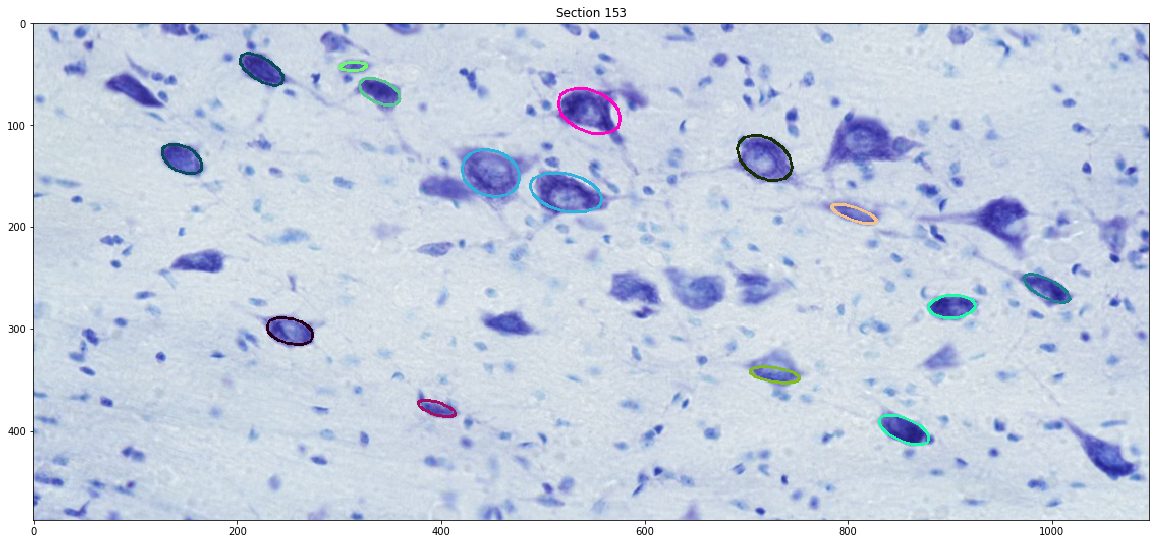

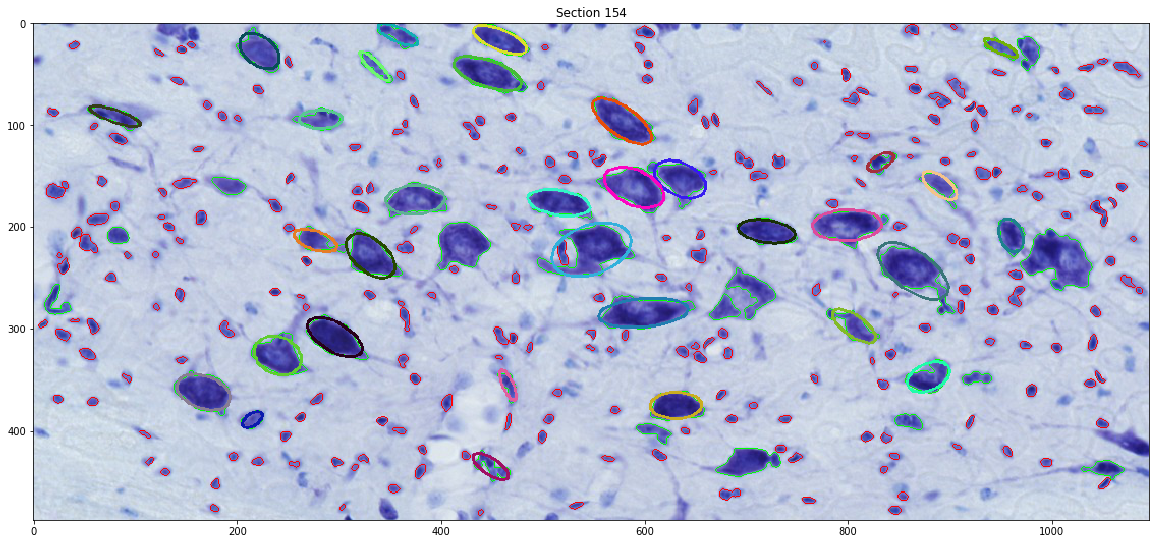

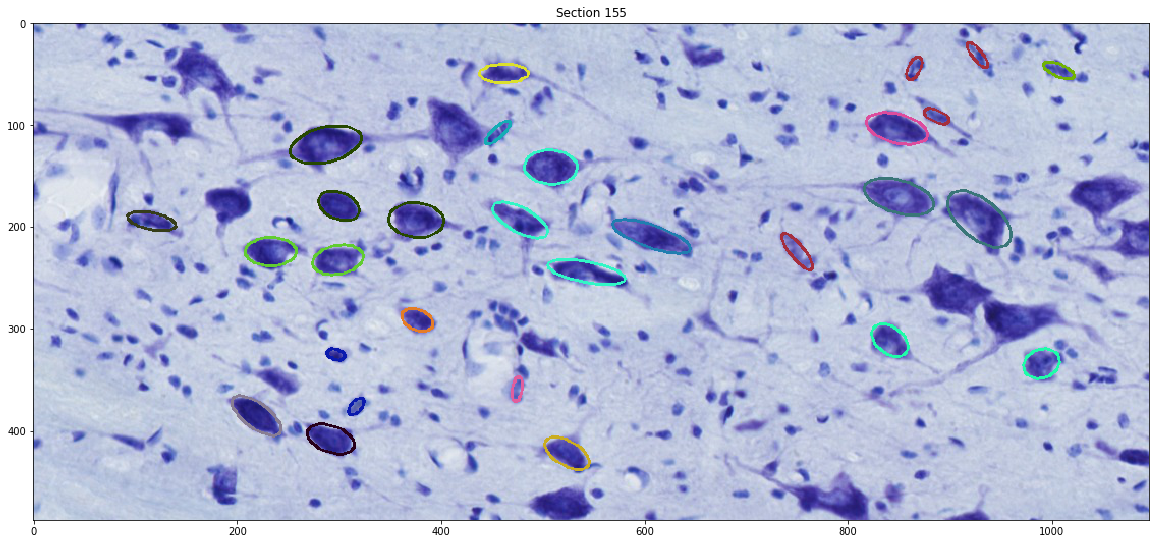

In [139]:
plt.figure(figsize=(20,20))
plt.imshow(matched_fig_blob_vis[153])
plt.title('Section 153')
plt.figure(figsize=(20,20))
plt.imshow(curr_fig_blob_vis[section])
plt.title('Section 154')
plt.figure(figsize=(20,20))
plt.imshow(matched_fig_blob_vis[155])
plt.title('Section 155')

In [143]:
display_image()

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: tmp.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

In [168]:
# Construct joined image:
# How to add a stripe between each image while not change the display color? 
stacked_dimension = 0; #0 for row stack, 1 for column stack
tempSpacing = 50
if stacked_dimension == 0:
    tempSpacingImage = np.zeros([tempSpacing, scan_parameters['im1max'],3],dtype=np.uint8) + 255
elif stacked_dimension == 1:
    tempSpacingImage = np.zeros([scan_parameters['im0max'], tempSpacing,3],dtype=np.uint8) + 255
tempImageList = []

for tempIdx in range(0, scan_parameters['scan_section_range']):
    continue
    tempSec = scan_section[tempIdx]
    tempImageList.append(matched_fig_blob_vis[tempSec])
    tempImageList.append(tempSpacingImage)    
tempImageList.append(curr_fig_blob_vis[section])
for tempIdx in range(scan_parameters['scan_section_range'], scan_parameters['scan_section_range']*2):
    
    tempSec = scan_section[tempIdx]
    tempImageList.append(tempSpacingImage)
    tempImageList.append(matched_fig_blob_vis[tempSec])
if stacked_dimension == 0:
    combined_image = np.row_stack(tuple(tempImageList))
elif stacked_dimension == 1:
    combined_image = np.column_stack(tuple(tempImageList))
# plt.figure(figsize=(15,15))
# plt.imshow(combined_image)
display_image(combined_image)

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

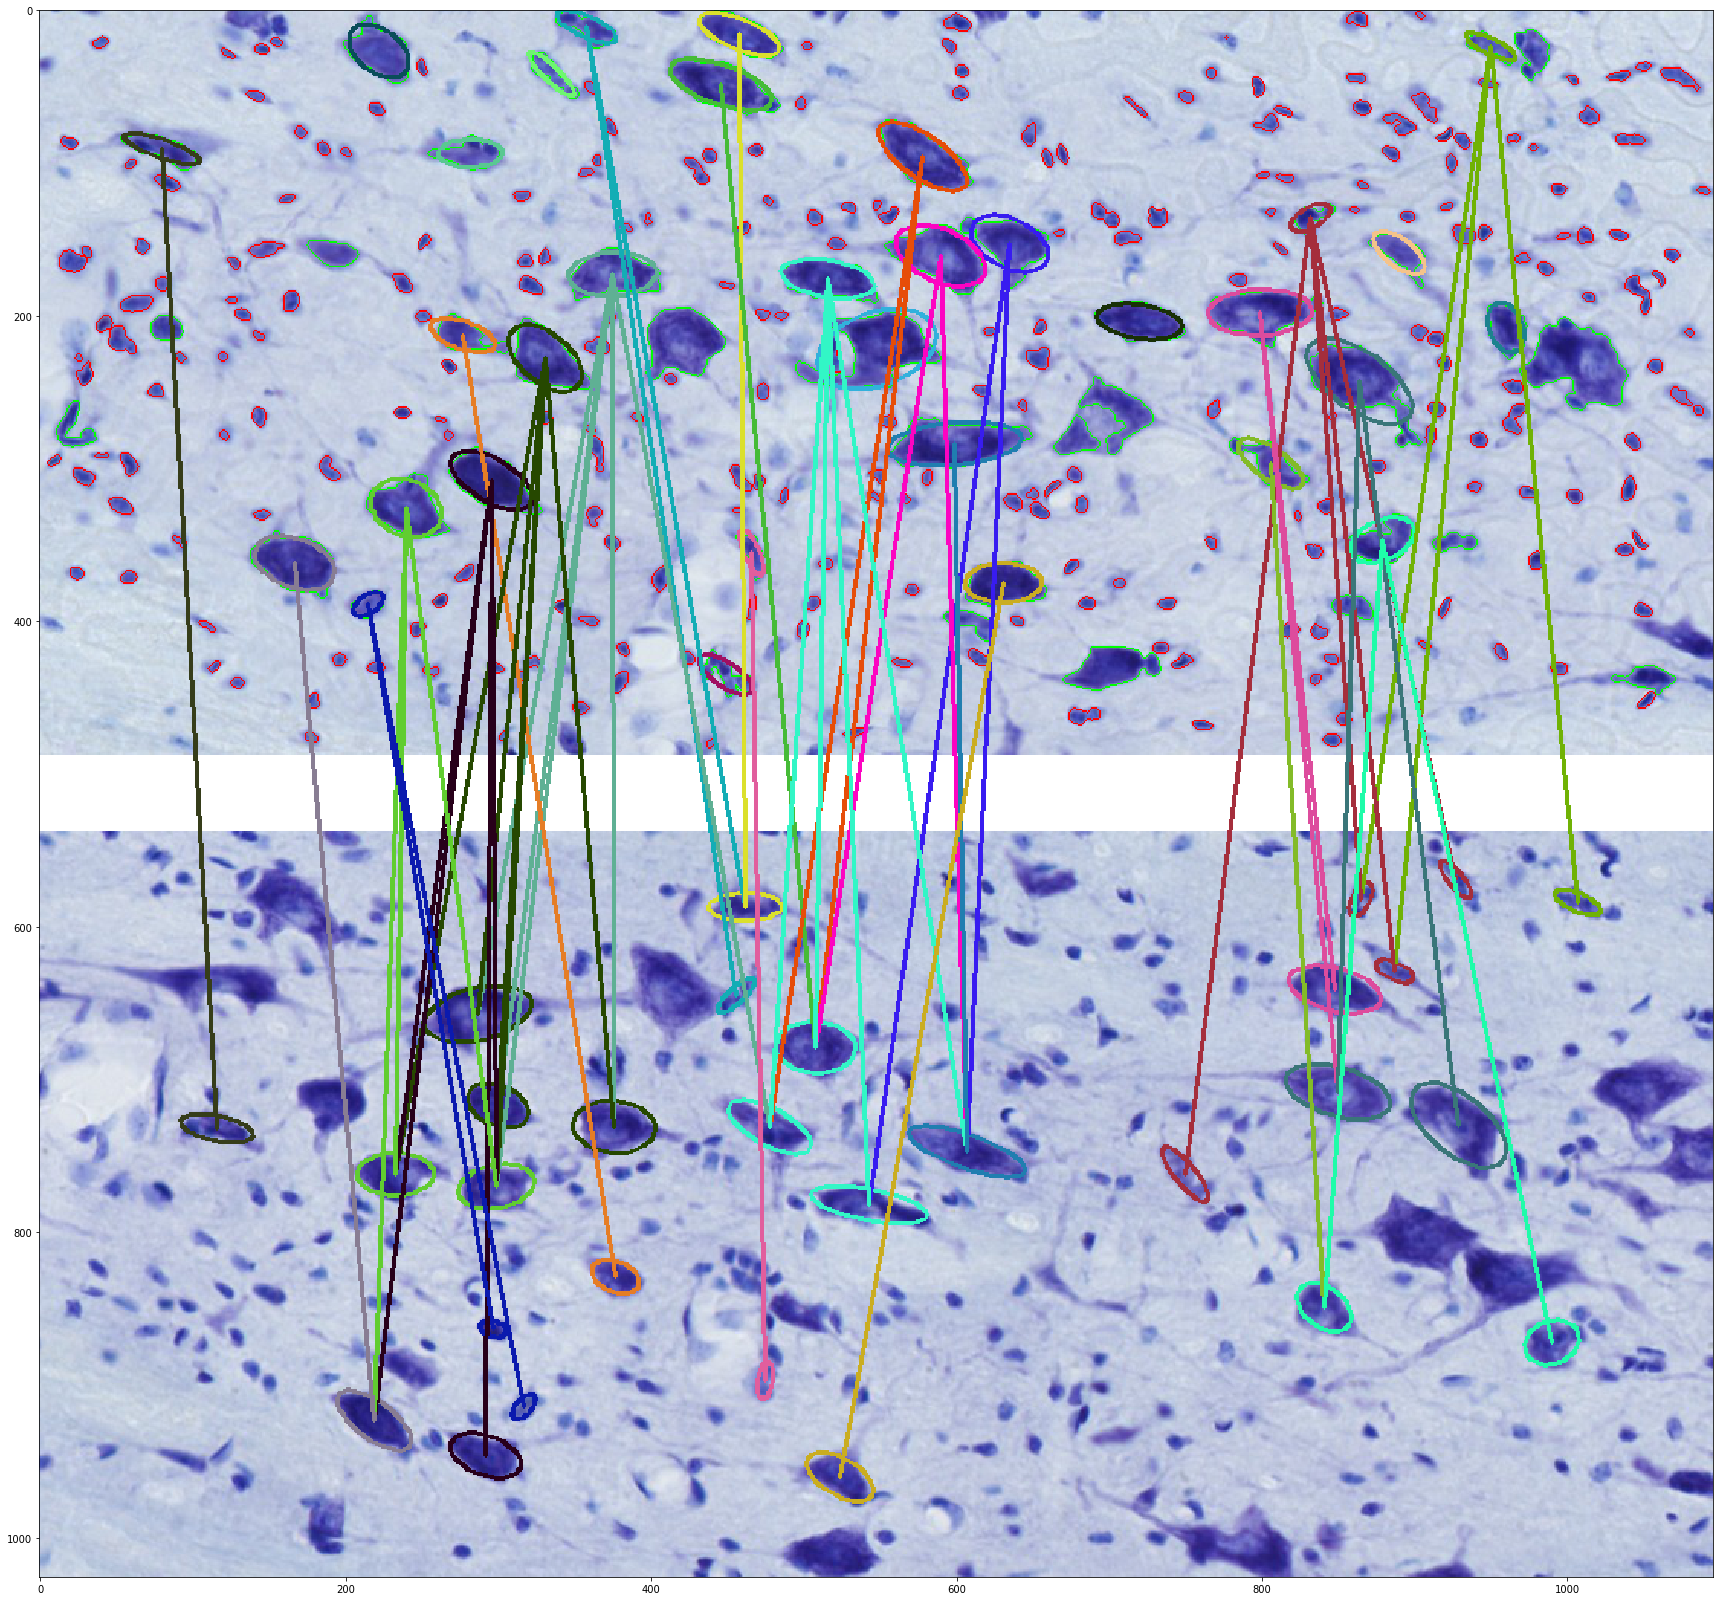

In [169]:

image_shifted_step = np.shape(curr_fig_blob_vis[section])[stacked_dimension] + tempSpacing

for matched_blob_id in range(len(matched_paris)):
# for matched_blob_id in [50]:
#     print(matched_blob_id)
    curr_blob_section = matched_paris[matched_blob_id][0]
    curr_blob_id = matched_paris[matched_blob_id][1]
    curr_blob_regionprops = matched_paris[matched_blob_id][2]
    scan_blobs_section = matched_paris[matched_blob_id][3]
    scan_blobs_ids = matched_paris[matched_blob_id][4]
    scan_blobs_regionprops = matched_paris[matched_blob_id][5]  
    curr_x_np, curr_y_np = curr_blob_regionprops['centroid']
    if stacked_dimension == 1:
        curr_y_np = curr_y_np + image_shifted_step * scan_parameters['scan_section_range']
    elif stacked_dimension == 0:
#         curr_x_np = curr_x_np + image_shifted_step * scan_parameters['scan_section_range']
        pass 
    
    for scan_blob_id in scan_blobs_ids:
        matched_x_np, matched_y_np = blob_prop_dic[scan_blobs_section]['centroid'][scan_blob_id]
        if stacked_dimension == 1:
            matched_y_np = matched_y_np + image_shifted_step * (scan_parameters['scan_section_range'] - section + scan_blobs_section)
        elif stacked_dimension == 0:
#             matched_x_np = matched_x_np + image_shifted_step * (scan_parameters['scan_section_range'] - section + scan_blobs_section)
            matched_x_np = matched_x_np + image_shifted_step * ( - section + scan_blobs_section)
        # for scan_blob_id in scan_blobs_ids:
        if scan_blobs_section == scan_section[0]:
            continue
        else:
            cv2.line(combined_image,(int(curr_y_np),int(curr_x_np)),(int(matched_y_np), int(matched_x_np)),map_color[curr_blob_id],2)
plt.figure(figsize=(30,30))
plt.imshow(combined_image)
display_image(combined_image)

In [150]:
display_image(combined_image)

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

This figure shows lines between matched pairs. 

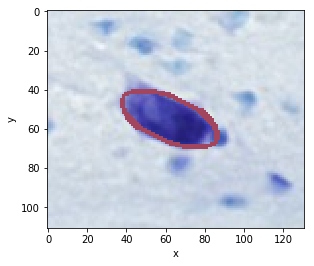

In [94]:
# Rotation angle of the ellipse in openCV is defined in left-handed coordinate
tempBID = 657
tempMargin = 40
tempImage = fun_crop_images(image[section],*im_blob_prop[section][tempBID]['bbox'],im0max=scan_parameters['im0max'],im1max=scan_parameters['im1max'],margin=tempMargin)
plt.imshow(tempImage)
plt.xlabel('x')
plt.ylabel('y')

local_pos = np.array(im_blob_prop[section][tempBID].local_centroid,dtype=np.int)[::-1]+tempMargin
# ellipse_angle = 180 - int(fun_angle_arc_to_degree(blob_prop_dic[curr_blob_section]['orientation'][tempBID]))
ellipse_angle = fun_angle_np_to_cv2(int(fun_angle_arc_to_degree(blob_prop_dic[curr_blob_section]['orientation'][tempBID])))
#     print(ellipse_angle)
# Draw ellipse
cell_contour = cv2.ellipse2Poly(tuple(local_pos),
            tuple([(0.5*blob_prop_dic[curr_blob_section]['major_axis_length'][tempBID]).astype(np.int),
                   (0.5*blob_prop_dic[curr_blob_section]['minor_axis_length'][tempBID]).astype(np.int)]),
           ellipse_angle,0,360,10)
cv2.polylines(tempImage, [cell_contour.astype(np.int32)], isClosed=True, color=map_color[curr_blob_id],thickness=2)

plt.imshow(tempImage)

In [162]:
display_image(matched_fig_blob_vis[152])

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

In [163]:
display_image(matched_fig_blob_vis[154])

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

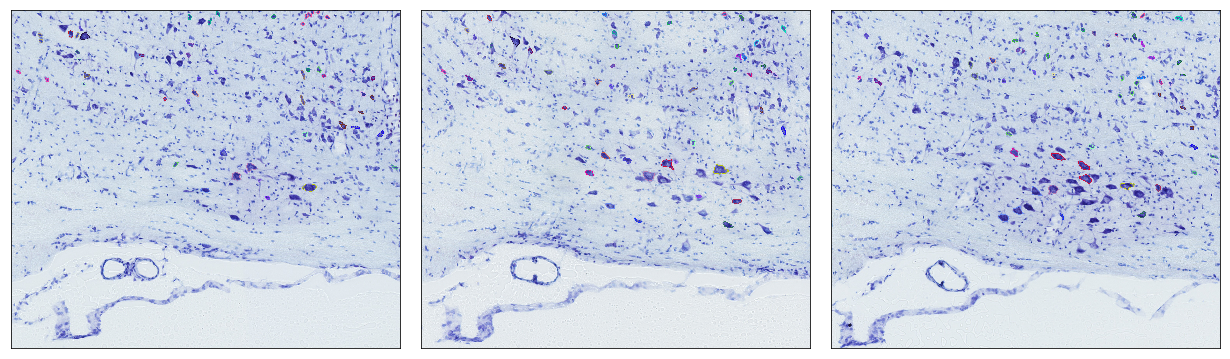

In [114]:
display_images_in_grids([matched_fig_blob_vis[152], curr_fig_blob_vis[section], matched_fig_blob_vis[154]],nc=3)